In [3]:
import pandas as pd
import geopandas as gpd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style='ticks')
sns.set_context('paper')

In [4]:
gdf = gpd.read_file('../GENERATED-DATA/od_crime_census_by_tract_filtered.geojson')
gdf.shape, type(gdf)

((3045, 78), geopandas.geodataframe.GeoDataFrame)

In [5]:
gdf.DISTRITO.value_counts()

DISTRITO
VILA MARIANA       124
PINHEIROS          114
JARDIM PAULISTA    110
ITAIM BIBI         106
PERDIZES            99
                  ... 
PEDREIRA             5
GUAIANASES           4
VILA MEDEIROS        4
PERUS                4
PONTE RASA           2
Name: count, Length: 96, dtype: int64

### Classification of Hotspots

In [8]:
gdf['CRIMES'].quantile([0.95])

0.95    279.2
Name: CRIMES, dtype: float64

In [9]:
def bin_target(y):
    # bins = y.quantile([0.25, 0.5, 0.75])
    bins = y.quantile([0.95])
    return y.apply(lambda x: sum(x > bins))

y = bin_target(gdf['CRIMES'])

In [11]:
y.value_counts()

CRIMES
0    2892
1     153
Name: count, dtype: int64

In [12]:
gdf['hotspot'] = y

In [15]:
df = gdf.drop(columns=['geometry', 'CRIMES', 'DISTRITO'])
df.columns

Index(['idade', 'grau_ins', 'vl_ren_i', 'sexo_Masculino',
       'estuda_2º grau/ Médio', 'estuda_Creche/ Pré-escola', 'estuda_Não',
       'estuda_Outros', 'estuda_Superior/ Universitário',
       'cd_ativi_Dona de Casa', 'cd_ativi_Em Licença Médica',
       'cd_ativi_Estudante', 'cd_ativi_Faz Bico', 'cd_ativi_Nunca Trabalhou',
       'cd_ativi_Sem Trabalho', 'cd_ativi_Tem Trabalho Regular',
       'co_ren_i_Não tem renda', 'co_ren_i_Tem renda', 'motivo_o_Compras',
       'motivo_o_Escola/Educação', 'motivo_o_Médico/Dentista/Saúde',
       'motivo_o_Procurar Emprego', 'motivo_o_Recreação/Visitas/Lazer',
       'motivo_o_Refeição', 'motivo_o_Residência',
       'motivo_o_Trabalho Comércio', 'motivo_o_Trabalho Indústria',
       'motivo_o_Trabalho Serviços', 'motivo_d_Compras',
       'motivo_d_Escola/Educação', 'motivo_d_Médico/Dentista/Saúde',
       'motivo_d_Procurar Emprego', 'motivo_d_Recreação/Visitas/Lazer',
       'motivo_d_Refeição', 'motivo_d_Residência',
       'motivo_d_Tra

In [16]:
from imblearn.over_sampling import SMOTE

def balance_classes(X, y):
    smote = SMOTE(sampling_strategy='auto', random_state=0)
    X_res, y_res = smote.fit_resample(X, y)
    return X_res, y_res

In [17]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

def predict_func(X_train, X_test, y_train, y_test):
    X_train, y_train = balance_classes(X_train, y_train)

    xgb = XGBClassifier(
        scale_pos_weight=1,  # Adjust based on the imbalance ratio
        eval_metric='aucpr',
        objective='binary:logistic',
    )

    xgb.fit(X_train, y_train)
    y_pred = xgb.predict(X_test)
    result = classification_report(y_test, y_pred, output_dict=True)
    return result


In [23]:
# import train_test_split
from sklearn.model_selection import train_test_split

X = df.drop(columns=['hotspot'])
y = df['hotspot']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [31]:
y_train.value_counts(), y_test.value_counts()

(hotspot
 0    2315
 1     121
 Name: count, dtype: int64,
 hotspot
 0    577
 1     32
 Name: count, dtype: int64)

In [32]:
from sklearn.model_selection import cross_val_predict

xgb = XGBClassifier(
    scale_pos_weight=1,  # Adjust based on the imbalance ratio
    eval_metric='aucpr',
    objective='binary:logistic',
)

xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       577
           1       0.44      0.12      0.20        32

    accuracy                           0.95       609
   macro avg       0.70      0.56      0.58       609
weighted avg       0.93      0.95      0.93       609



### Regression of Crimes

In [20]:
df = gdf.drop(columns=['DISTRITO', 'geometry'])

In [21]:
X = df.drop(columns=['CRIMES'])
features = X.columns
y = df['CRIMES']

In [14]:
zero_threshold = 0.5
zero_proportion = (X == 0).mean()
features_to_drop = zero_proportion[zero_proportion > zero_threshold].index
features_to_drop

Index(['estuda_2º grau/ Médio', 'estuda_Creche/ Pré-escola', 'estuda_Outros',
       'cd_ativi_Dona de Casa', 'cd_ativi_Em Licença Médica',
       'cd_ativi_Faz Bico', 'cd_ativi_Nunca Trabalhou',
       'cd_ativi_Sem Trabalho', 'motivo_o_Compras',
       'motivo_o_Médico/Dentista/Saúde', 'motivo_o_Procurar Emprego',
       'motivo_o_Recreação/Visitas/Lazer', 'motivo_o_Refeição',
       'motivo_o_Trabalho Comércio', 'motivo_o_Trabalho Indústria',
       'motivo_d_Compras', 'motivo_d_Médico/Dentista/Saúde',
       'motivo_d_Procurar Emprego', 'motivo_d_Recreação/Visitas/Lazer',
       'motivo_d_Refeição', 'motivo_d_Trabalho Comércio',
       'motivo_d_Trabalho Indústria', 'V003_ENTORNO01', 'V001_DOMICILIORENDA',
       'V004_DOMICILIORENDA', 'V006_PESSOA03'],
      dtype='object')

In [15]:
X = X.drop(columns=features_to_drop)

In [22]:
# normalize the data
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = scaler.fit_transform(X)

In [23]:
X.shape, y.shape

((3045, 75), (3045,))

#### Feature Importance

In [25]:
from sklearn.feature_selection import SelectKBest, r_regression, f_regression, mutual_info_regression

r_selector = SelectKBest(score_func=r_regression, k='all')
r_selector.fit(X, y)

mi_selector = SelectKBest(score_func=mutual_info_regression, k='all')
mi_selector.fit(X, y)

r = pd.DataFrame({'feature': features, 'r': r_selector.scores_, 'mi': mi_selector.scores_})
r = r.sort_values('r', ascending=False)
r

# this changed

,feature,r,mi
38,viagens,0.555564,0.114957
37,motivo_d_Trabalho Serviços,0.231269,0.063635
23,motivo_o_Refeição,0.188478,0.093626
33,motivo_d_Refeição,0.187341,0.013993
24,motivo_o_Residência,0.176622,0.134632
...,...,...,...
5,estuda_Creche/ Pré-escola,-0.100544,0.041298
11,cd_ativi_Estudante,-0.116606,0.050385
16,co_ren_i_Não tem renda,-0.130278,0.053113
19,motivo_o_Escola/Educação,-0.148988,0.068008


In [26]:
selected_features = r.feature[:5]
selected_features

38                       viagens
37    motivo_d_Trabalho Serviços
23             motivo_o_Refeição
33             motivo_d_Refeição
24           motivo_o_Residência
Name: feature, dtype: object

#### Regression

In [27]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor

1. random forest with gridsearch 

In [28]:
def rf_gridsearch(X, y):
    rf_params = {
        'n_estimators': np.arange(23, 27, 1),
        'max_depth': np.arange(6, 12),
        'min_samples_split': np.arange(6, 12)
    }

    grid_search = GridSearchCV(
        RandomForestRegressor(),
        rf_params,
        cv=10,
        scoring='neg_mean_absolute_error',  # less weight for outliers
        n_jobs=-1, # parallelize
        verbose=4,
    )

    grid_search.fit(X, y)

    best_model = grid_search.best_estimator_
    best_scores = grid_search.best_score_

    return best_model, best_scores

In [29]:
best_model, best_scores = rf_gridsearch(X, y)
best_scores

Fitting 10 folds for each of 144 candidates, totalling 1440 fits


-62.699586381559435

2. use best model to find outliers and remove them

In [31]:
def get_residual_outliers(model, X, y):
    y_pred = cross_val_predict(model, X, y, cv=10, n_jobs=-1)
    residuals = y - y_pred

    mean_residual = np.mean(residuals)
    std_residual = np.std(residuals)
    threshold = 2 * std_residual
    outliers = np.abs(residuals) > threshold

    return residuals, outliers

In [32]:
residuals, outliers = get_residual_outliers(best_model, X, y)
sum(outliers)

102

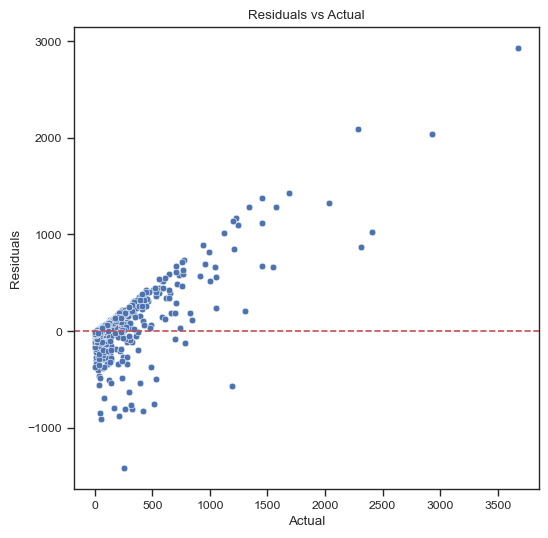

In [33]:
def plot_res(y, residuals):
    f, ax = plt.subplots(figsize=(6, 6))
    sns.scatterplot(x=y, y=residuals, ax=ax)

    ax.axhline(0, color='r', linestyle='--')
    ax.set_xlabel('Actual')
    ax.set_ylabel('Residuals')
    ax.set_title('Residuals vs Actual')
    #ax.set_xlim(0, 1000)

    plt.show()

plot_res(y, residuals)

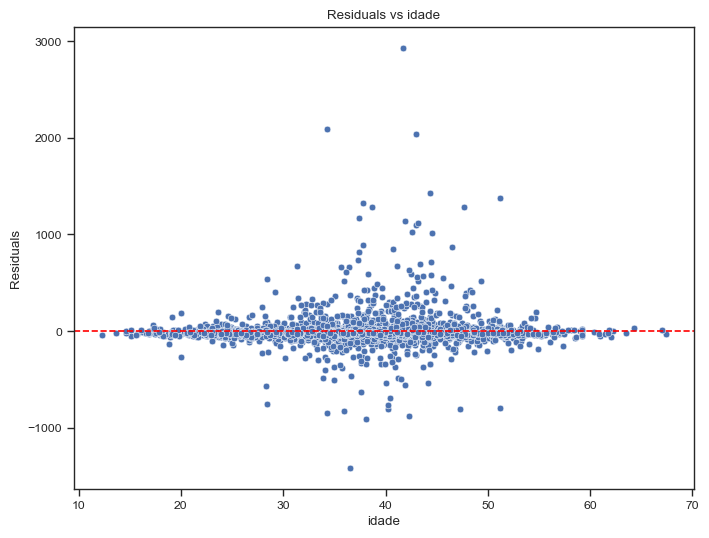

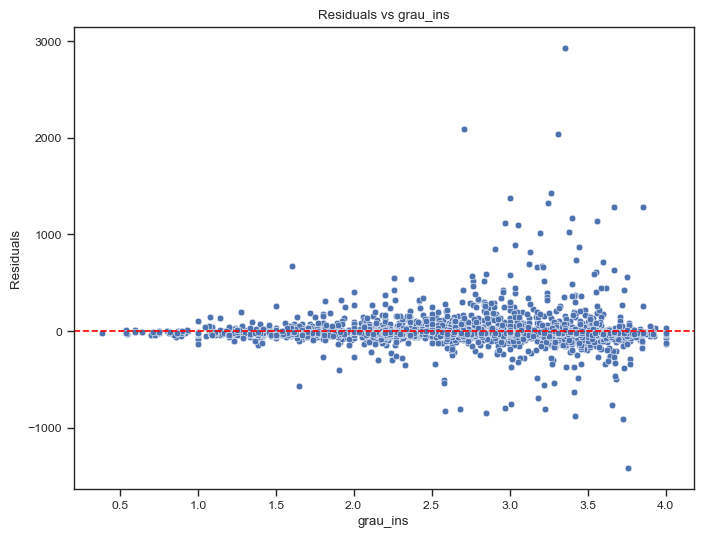

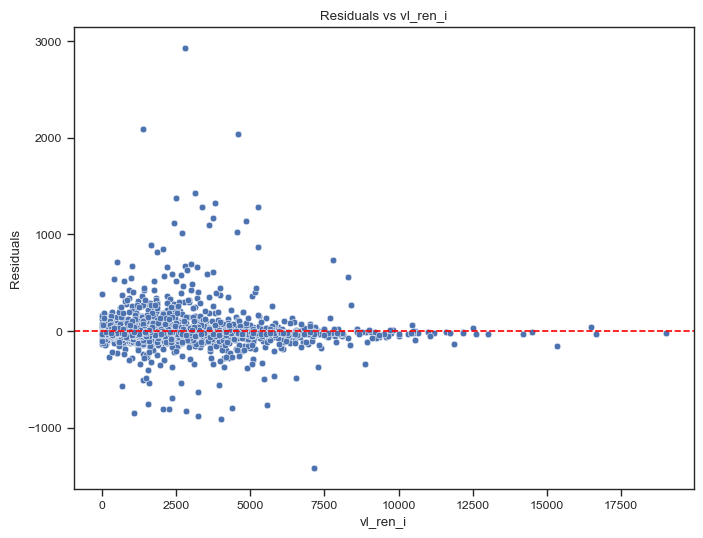

In [34]:
for feature in features[:3]:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=df[feature], y=residuals)
    plt.axhline(0, color='red', linestyle='--')
    plt.title(f'Residuals vs {feature}')
    plt.xlabel(f'{feature}')
    plt.ylabel('Residuals')
    plt.show()


In [35]:
from statsmodels.stats.diagnostic import het_breuschpagan
import statsmodels.api as sm

# Assuming y_test and residuals are already available
exog = sm.add_constant(X)  # Add a constant to features
bp_test = het_breuschpagan(residuals, exog)

# Output test statistics
print('Breusch-Pagan Test:')
print(f'Lagrange multiplier statistic: {bp_test[0]}')
print(f'p-value: {bp_test[1]}')

if bp_test[1] < 0.05:
    print('Heteroscedasticity detected (p < 0.05)')
else:
    print('No heteroscedasticity detected (p >= 0.05)')


Breusch-Pagan Test:
Lagrange multiplier statistic: 498.79383745889425
p-value: 7.762935672192385e-64
Heteroscedasticity detected (p < 0.05)


In [360]:
y_log = np.log1p(y)

In [361]:
best_model, best_scores = rf_gridsearch(X, y_log)
best_scores

Fitting 10 folds for each of 144 candidates, totalling 1440 fits


-0.9064789234264922

In [362]:
residuals, outliers = get_residual_outliers(best_model, X, y_log)
sum(outliers)

145

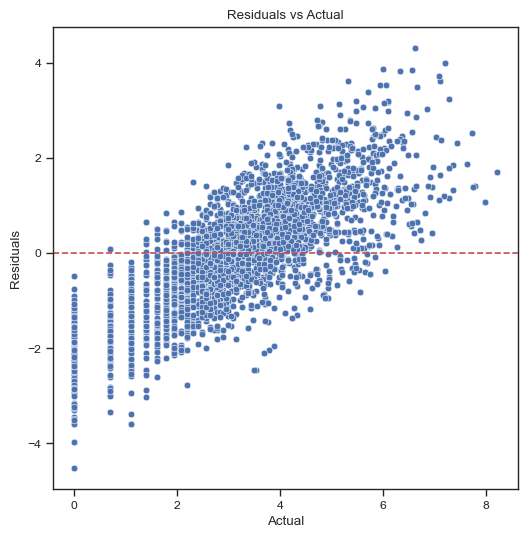

In [363]:
plot_res(y_log, residuals)

In [365]:
from sklearn.preprocessing import FunctionTransformer

# Log-transform specific features (positive values only)
log_transformer = FunctionTransformer(np.log1p, validate=True)  # log1p handles zeroes

# Apply log transformation to features (if needed)
X_transformed = log_transformer.transform(X)

# Train the model on transformed features
best_model, best_scores = rf_gridsearch(X_transformed, y_log)
best_scores

C:\Users\arthu\AppData\Roaming\Python\Python312\site-packages\sklearn\preprocessing\_function_transformer.py:394: RuntimeWarning: invalid value encountered in log1p
  return func(X, **(kw_args if kw_args else {}))


Fitting 10 folds for each of 144 candidates, totalling 1440 fits


-0.9181151088898906

3. rf again but now without outliers

In [36]:
rf_params = {
    'n_estimators': np.arange(25, 30, 1),
    'max_depth': np.arange(6, 10),
    'min_samples_split': np.arange(6, 10)
}

grid_search = GridSearchCV(
    RandomForestRegressor(),
    rf_params,
    cv=5,
    scoring='neg_mean_absolute_error',  # less weight for outliers
    n_jobs=-1, # parallelize
    verbose=3,
)

grid_search.fit(X[~outliers], y[~outliers])

best_model = grid_search.best_estimator_
best_scores = grid_search.best_score_
best_model, best_scores

Fitting 5 folds for each of 80 candidates, totalling 400 fits


(RandomForestRegressor(max_depth=8, min_samples_split=8, n_estimators=29),
 -37.309028974690975)

In [40]:
# r2 of the model
from sklearn.metrics import r2_score

y_pred = cross_val_predict(best_model, X[~outliers], y[~outliers], cv=10, n_jobs=-1)
r2 = r2_score(y[~outliers], y_pred)


In [41]:
r2

0.4335022969577341

In [37]:
y[~outliers].max() - y[~outliers].min()

1304

In [48]:
(y[~outliers] - y[~outliers].mean()).abs().mean()

48.66040013397607

In [49]:
37.309028974690975 / 48.66040013397607

0.7667226095956567

In [284]:
from xgboost import XGBRegressor

xgb_params = {
    'n_estimators': np.arange(10, 30, 1),
}

grid_search = GridSearchCV(
    XGBRegressor(),
    xgb_params,
    cv=5,
    scoring='neg_mean_absolute_error',  # less weight for outliers
    n_jobs=-1, # parallelize
    verbose=4,
)

grid_search.fit(X[~outliers], y[~outliers])

best_model = grid_search.best_estimator_
best_scores = grid_search.best_score_
best_model, best_scores


Fitting 5 folds for each of 320 candidates, totalling 1600 fits


C:\Users\arthu\AppData\Roaming\Python\Python312\site-packages\xgboost\core.py:158: UserWarning: [20:12:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)


(XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, min_samples_split=8, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=10,
              n_jobs=None, num_parallel_tree=None, ...),
 -38.4000649288119)

4. evaluate

In [50]:
cross_val_score(best_model, X[~outliers], y[~outliers], cv=10, scoring='r2')

array([0.528195  , 0.10123594, 0.25722393, 0.49049372, 0.45030545,
       0.26113105, 0.45157332, 0.07983267, 0.59800848, 0.37236272])

#### Testing?

In [ ]:


# Calculate residuals
residuals = y_test - y_pred

# Analyze residuals
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

# Compute statistics
mean_residual = np.mean(residuals)
std_residual = np.std(residuals)

# Define outlier threshold
threshold = 2 * std_residual

In [202]:


param_grid = {
    'alpha': np.linspace(1020, 1023),
    'fit_intercept': [True, False],
}

grid_search = GridSearchCV(Ridge(), param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X, y)
best_model = grid_search.best_estimator_
best_scores = grid_search.best_score_
best_model, best_scores

(Ridge(alpha=1020.0), -698.1223763992314)

In [203]:
from sklearn.linear_model import HuberRegressor

reg = HuberRegressor()

scores = cross_val_score(HuberRegressor(), X, y, cv=5, scoring='r2')
print(f'Cross-validated R² scores: {scores}')

Cross-validated R² scores: [-0.01072798 -0.02018264  0.11474629  0.06643604  0.11307393]


In [204]:
param_grid = {
    'alpha':  np.linspace(10, 11),
    'max_iter': [1000],
}

grid_search = GridSearchCV(Lasso(), param_grid, cv=5, scoring='r2')
grid_search.fit(X, y)
best_model = grid_search.best_estimator_
best_scores = grid_search.best_score_

best_model, best_scores

(Lasso(alpha=10.0), -0.0015510715084349424)

In [157]:
np.arange(0, 100),

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
        85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]),)

In [159]:
rf_params = {
    'n_estimators': np.arange(10, 30, 1),
    'max_depth': np.arange(8, 12),
    'min_samples_split': np.arange(8, 12)
}

grid_search = GridSearchCV(RandomForestRegressor(), rf_params, cv=5, scoring='r2')
grid_search.fit(X, y)
best_model = grid_search.best_estimator_
best_scores = grid_search.best_score_
best_model, best_scores

(RandomForestRegressor(max_depth=9, min_samples_split=11, n_estimators=16),
 0.1891152641641068)

In [205]:
from sklearn.model_selection import cross_val_score
from sklearn import linear_model

lm = linear_model.Lasso(max_iter=20000)
cross_val_score(lm, X, y, cv=10, scoring='r2')

array([0.02511143, 0.0641257 , 0.03319608, 0.04525031, 0.13776675,
       0.16101273, 0.12759534, 0.10425826, 0.12012392, 0.14897225])

In [213]:
X = gdf[['viagens']]
y = gdf['CRIMES']

In [214]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(random_state=0)
cross_val_score(rf, X, y, cv=10, scoring='r2')

array([-0.37951782, -0.46473196, -0.01540786, -0.17715883,  0.46187553,
        0.10735299,  0.24489756,  0.08349724,  0.47916675, -0.76245378])

In [207]:
# xgboost regressor
from xgboost import XGBRegressor

xgb = XGBRegressor(objective='reg:squarederror')
cross_val_score(xgb, X, y, cv=10, scoring='r2')

array([-0.32068408, -0.15901268, -0.29645507, -0.167145  , -0.0620628 ,
        0.04512241, -0.1518359 , -0.12179416, -0.2770912 , -0.04652732])

In [208]:
from sklearn import svm
regr = svm.SVR()
cross_val_score(regr, X, y, cv=10, scoring='r2')

array([ 0.00254093, -0.07771168, -0.04886354, -0.07186726,  0.00671059,
        0.1026598 ,  0.05535741,  0.00511471,  0.05484053,  0.04555673])